# Movie Recommendation System Using Collaborative and Hybrid Filtering

## 1. Business Understanding

### 1.1 Project Overview
Recommendation systems are an essential feature of modern streaming platforms, helping users discover content that matches their interests in large and diverse catalogs. Well-designed recommendations improve user experience, increase engagement, and encourage continued use of the platform.

This project focuses on building a movie recommendation system using the MovieLens *ml-latest-small* dataset. The primary approach is **collaborative filtering with Singular Value Decomposition (SVD)**, which learns user preferences from historical rating patterns. To improve recommendation quality and handle cases where limited user data is available, a **hybrid approach** is used by incorporating movie genre information and user rating preferences.

---

### 1.2 Business Problem Statement
A movie streaming platform wants to provide more relevant movie recommendations to its users. Without personalized recommendations, users may find it difficult to discover movies they are likely to enjoy, which can reduce satisfaction and engagement.

The goal is to use past user ratings to understand individual preferences and generate accurate, personalized recommendations, even for users with relatively few ratings.

---

### 1.3 Project Objectives
- Build a **hybrid movie recommendation system** combining collaborative filtering (SVD) and content-based filtering using genre information.
- Produce **personalized top-5 movie recommendations** for each user.
- Evaluate model performance using validation techniques and **rating prediction error metrics**.

---

### 1.4 Research Questions
- How well does SVD-based collaborative filtering capture user preferences from historical ratings?
- How accurately can the model predict ratings for movies a user has not yet rated?
- Does adding content-based information improve recommendations compared to using collaborative filtering alone?

---

## 2. Data Understanding

### 2.1 Dataset Overview
The MovieLens *ml-latest-small* dataset is a publicly available dataset created by the **GroupLens Research Lab at the University of Minnesota**. It contains explicit user ratings and metadata collected from the MovieLens platform between 1996 and 2018.

Key characteristics of the dataset include:
- **100,836** movie ratings  
- **3,683** user-applied tags  
- **9,742** unique movies  
- **610** anonymized users  
- Ratings on a **0.5 to 5.0 star scale**

Each user has rated at least 20 movies, making the dataset suitable for collaborative filtering and matrix factorization methods such as SVD.

---

### 2.2 Data Files
The dataset is provided in four CSV files:
- **ratings.csv**: User ratings for movies, including timestamps  
- **movies.csv**: Movie titles and associated genre labels  
- **tags.csv**: User-generated tags for movies  
- **links.csv**: External identifiers linking movies to IMDb and TMDB

In [2]:
import os
os.chdir(r'c:\Users\valar\Documents\Flatiron\Assignments\Phase 4\Project\Phase-4-Project---Movie-Recommendation-System')
os.getcwd()



'c:\\Users\\valar\\Documents\\Flatiron\\Assignments\\Phase 4\\Project\\Phase-4-Project---Movie-Recommendation-System'

## 3. Data Preparation
### 3.1 Data exploration
We are only going to use the ratings.csv file and movies.csv file.
I am going to : Check there is no null values
                drop 'timestamp' column on ratings.csv as we will not be using this column.
                Merge ratings.csv and movies.csv.

In [3]:
# load the dataset
import pandas as pd
import numpy as np

df = pd.read_csv("./data/ratings.csv")
mov_df = pd.read_csv("./data/movies.csv")
tags_df = pd.read_csv("./data/tags.csv")
links_df = pd.read_csv("./data/links.csv")

# Checking shape of each df
print("Ratings shape:", df.shape)
print("Mov_df shape:", mov_df.shape)
print("Tags shape:", tags_df.shape)
print("Links shape:", links_df.shape)

# Inspect first few rows to confirm successful loading
df.head(), mov_df.head()


Ratings shape: (100836, 4)
Mov_df shape: (9742, 3)
Tags shape: (3683, 4)
Links shape: (9742, 3)


(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

In [4]:
# ratings df has 4 columns , Dtype - int64 and float64
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
# dropping the timestamp column as we don't need it
df = df.drop(['timestamp'],axis=1)

# checking that there are no null values in our dataset
print("sum of null values in ratings df", df.isna().sum().sum())
print("sum of null values in mov_df", mov_df.isna().sum().sum())
# checking that there are no duplicated rows
print("sum of any duplicate rows in ratings df", df.duplicated().sum())
print("sum of any duplicate rows in mov_df", mov_df.duplicated().sum())


sum of null values in ratings df 0
sum of null values in mov_df 0
sum of any duplicate rows in ratings df 0
sum of any duplicate rows in mov_df 0


### 3.2 Basic Statistics


In [8]:
# User & Movie counts
print("\nUser & Movie Statistics:")
print(f"Unique Users: {df['userId'].nunique():,}")
print(f"Unique Movies: {df['movieId'].nunique():,}")


User & Movie Statistics:
Unique Users: 610
Unique Movies: 9,724


In [9]:
# Calculate sparsity
sparsity = (1 - len(df) / (df['userId'].nunique() * df['movieId'].nunique())) * 100
print(f"Sparsity: {sparsity:.2f}%")
print(f"\n💡 Sparsity shows that {sparsity:.1f}% of user-movie combinations have no rating.")

Sparsity: 98.30%

💡 Sparsity shows that 98.3% of user-movie combinations have no rating.


Following the initial data exploration, the dataset consists of **9,742 movies** and **100,836 ratings** provided by **610 users**, resulting in a sparsity level of approximately **98.3%** in the user–item interaction matrix. Ratings are well-distributed within the **0.5 to 5.0** range, with a mean rating of **3.5**, indicating a slight tendency toward positive user feedback.

The high sparsity of the data suggests limited overlap in user–movie interactions, which presents a challenge for recommendation accuracy. This characteristic makes matrix factorization approaches such as SVD particularly suitable, as they are designed to uncover latent patterns in sparse rating data.


### 3.3 Data Intergration
Creating a combined table of ratings and movies:
Columns to keep: userId,movieId,ratings,title,genres

In [7]:
combined_df = pd.merge(df,mov_df,on= 'movieId')
print('combined df shape:', combined_df.shape)
# checking that there are no null values and no duplicated rows
print("sum of null values in combined df", combined_df.isna().sum().sum())
print("sum of any duplicate rows in combined df", combined_df.duplicated().sum())


combined_df.head()


combined df shape: (100836, 5)
sum of null values in combined df 0
sum of any duplicate rows in combined df 0


,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## Exploratory Data Analysis

The exploratory data analysis focuses on understanding user rating behavior and content characteristics that directly impact the performance of collaborative and hybrid recommendation systems. The analysis is guided by the following key questions:

1. How are User Ratings Distributed
2. Movie genre popularity: Which genres are most frequently rated
3.

1. How are User Ratings Distributed

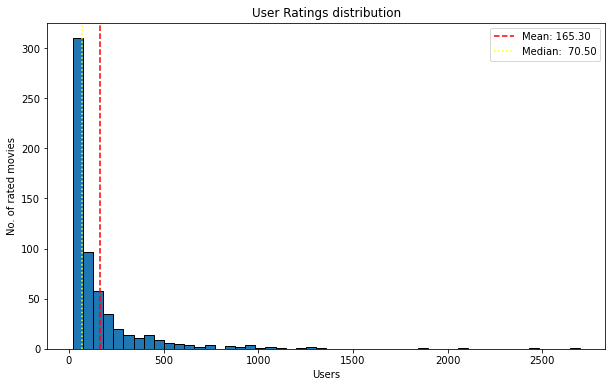

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
 
user_ratings_count = df.groupby('userId')['rating'].count()
# plotting histogram
plt.figure(figsize=(10,6))
plt.hist(user_ratings_count,bins = 50, edgecolor='black')
plt.title('User Ratings distribution')
plt.xlabel('Users')
plt.ylabel('No. of rated movies')
plt.axvline(user_ratings_count.mean(),linestyle= '--', color = 'red',label=f'Mean: {user_ratings_count.mean():.2f}')
plt.axvline(user_ratings_count.median(), linestyle = ':',color='yellow',label=f'Median: {user_ratings_count.median(): .2f}')
plt.legend()
plt.show()

This plot shows the distribution of the number of movies rated per user. While each user has rated at least 20 movies, most users rate relatively few movies compared to the full catalog, highlighting the sparsity of the user–item matrix.

### 4.2.1 Which movie genres are most frequently rated?

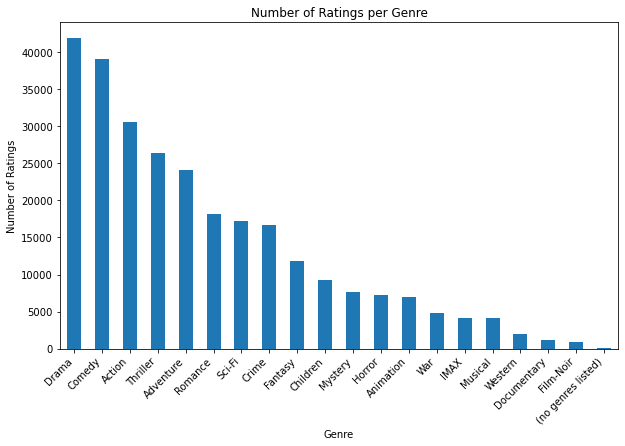

In [25]:
# explode genres
df_genre = combined_df.copy()
df_genre['genres'] = df_genre['genres'].str.split('|')
df_genre = df_genre.explode('genres')

# count ratings per genre
g_counts = df_genre['genres'].value_counts()

# plot
plt.figure(figsize=(10,6))
g_counts.plot(kind='bar')
plt.title('Number of Ratings per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.show()


### 4.2.2 Which genres are associated with high-quality, widely rated movies?

**Why this matters:**  
The hybrid recommendation system leverages genre information to improve recommendations. Instead of just looking at how many ratings a genre receives, this analysis uses a **weighted rating** that accounts for both the average rating and the number of votes. This provides a more reliable measure of genre-level quality.

In [20]:
df_new = combined_df.copy()
df_new['genres'] = df_new['genres'].apply(lambda x: x.split('|'))
df_new['avg_rating'] = df_new.groupby('title')['rating'].transform('mean')
df_new['num_votes'] = df_new.groupby('title')['rating'].transform('count')
df_new = df_new.explode('genres')
print(df_new.shape)
print(df_new.head())


(274480, 7)
   userId  movieId  rating             title     genres  avg_rating  num_votes
0       1        1     4.0  Toy Story (1995)  Adventure     3.92093        215
0       1        1     4.0  Toy Story (1995)  Animation     3.92093        215
0       1        1     4.0  Toy Story (1995)   Children     3.92093        215
0       1        1     4.0  Toy Story (1995)     Comedy     3.92093        215
0       1        1     4.0  Toy Story (1995)    Fantasy     3.92093        215


In [24]:
# Calculate average rating and num_votes() to get popularity metrics 
# #Computing weighted rating for each genre using IMDB'S weighted rating formula 
C = df_new["avg_rating"].mean() 
# getting only the top 10 most popular movies 
m = df_new["num_votes"].quantile(0.90) 
#filtering our dataframe and computing weighted_rating for top 10% of movies by votes 
top_10= df_new[df_new["num_votes"] >= m].copy() 
top_10["weighted_rating"] = ((top_10["num_votes"]/(top_10["num_votes"] + m)) * top_10["avg_rating"] + (m/(top_10["num_votes"] + m)) * C) 

# group top_10 df by genres and get movie count per genre 
genre_table = (top_10.groupby(["genres"]).agg(avg_weighted_rating=("weighted_rating", "mean"), num_movies=("title", "count")) .sort_values(by="num_movies", ascending=False)) 

genre_table = genre_table.reset_index() 
genre_table

,genres,avg_weighted_rating,num_movies
0,Action,3.736997,3820
1,Adventure,3.745994,3655
2,Drama,3.874521,3464
3,Thriller,3.763501,3336
4,Comedy,3.709404,2217
5,Sci-Fi,3.780051,2113
6,Crime,3.874363,2044
7,Fantasy,3.725849,1113
8,Mystery,3.762117,1084
9,Romance,3.742155,1052


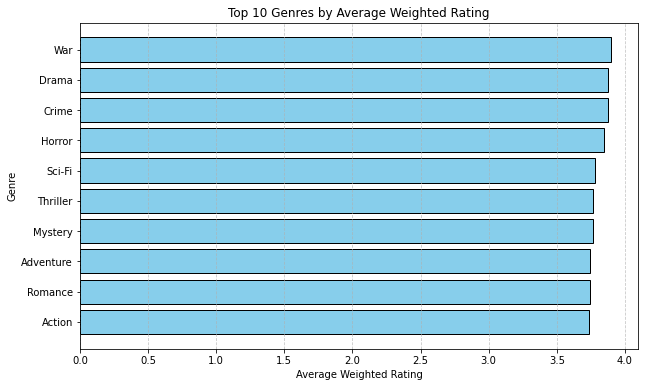

In [ ]:
# Sort genres by average weighted rating for plotting
# Sort by weighted rating and take top 10
top_genres = genre_table.sort_values(by='avg_weighted_rating', ascending=False).head(10)
top_genres = top_genres.sort_values('avg_weighted_rating')  # for horizontal bar plot

plt.figure(figsize=(10,6))
plt.barh(top_genres['genres'], top_genres['avg_weighted_rating'], color='skyblue', edgecolor='black')
plt.xlabel('Average Weighted Rating')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Average Weighted Rating')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## 5. Data Modeling

In [13]:
# changing out df into the surprise 
# importing surprise
from surprise import Reader,Dataset
reader = Reader()
df_surprise = Dataset.load_from_df(df,reader)

### Doing neighbour-based similarity models
Looking at how many user's vs items we have. 

In [14]:
dataset = df_surprise.build_full_trainset()
print('Number of users',dataset.n_users,'\n')
print('Number of items',dataset.n_items)

Number of users 610 

Number of items 9724


In [15]:
# importing necessary libraries
from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNBaseline,KNNWithMeans,KNNBasic


# Evaluating Model with SVD

In [16]:
# 
# param_grid = {'n_factors': [20,50,80],
#               'reg_all':[0.02,0.05],
#               'n_epochs':[15,20]}
# # Instantiate GridsearchCv 
# grid_svd = GridSearchCV(SVD,param_grid=param_grid,measures=['rmse'])

# # fitting to surprise dataset
# grid_svd.fit(df_surprise)


In [17]:
# print('Best Parameters:', grid_svd.best_params)
# print('Best Score', grid_svd.best_score)

Comparing our SVD model with KNNBasic,KNNBaseline,and KNNwithMeans

In [18]:

# cross-validating with KNNBasic
Basic = KNNBasic(sim_options={'name':'pearson','user_based':True})
cv_knn_basic = cross_validate(Basic,df_surprise,n_jobs=-1,measures=['rmse'])

In [19]:
Basic_trmse = np.mean(cv_knn_basic['test_rmse'])
print('Average test RMSE is:', Basic_trmse)

Average test RMSE is: 0.973456090061543


KNNBaseline

In [20]:
Baseline = KNNBaseline(sim_options={'name':"pearson",'user_based': True})
cv_knn_baseline = cross_validate(Baseline,df_surprise,n_jobs=-1,measures = ['rmse'])

Baseline_trmse = np.mean(cv_knn_baseline['test_rmse'])
print('Average test RMSE is:',Baseline_trmse )

Average test RMSE is: 0.8772424660880693


# KNNwithMeans

In [21]:
KwMeans = KNNWithMeans(sim_options={'name':"pearson",'user_based': True})
cv_knn_wMeans = cross_validate(KwMeans,df_surprise,n_jobs=-1,measures = ['rmse'])

kwMeans_trmse = np.mean(cv_knn_wMeans['test_rmse'])
print('Average test RMSE is:', kwMeans_trmse)

Average test RMSE is: 0.8957626144166999


In [22]:
# Summary = [{'Model': 'SVD', 'Best RMSE': grid_svd.best_score},
#            {'Model': 'KNNBasic', 'Best RMSE': Basic_trmse},
#            {'Model': 'KNNBaseline', 'Best RMSE': Baseline_trmse},
#            {'Model': 'KNNWithMeans', 'Best RMSE': kwMeans_trmse},]

# df_summary = pd.DataFrame(Summary)
# df_summary

# Making Movie Recommendations with SVD
SVD had the lowest rmse score at 0.86. We are going to fit and make predictions on this model.

In [23]:
# Instantiat an SVD model
# from GridSearch, Best Params: {'n_factors': 50, 'reg_all': 0.05, 'n_epochs': 20}}

svd = SVD(n_factors=50,reg_all=0.05,n_epochs=20)
svd.fit(dataset)

In [24]:
# Example prediction
svd.predict(1,3)

Prediction(uid=1, iid=3, r_ui=None, est=4.1081183071408, details={'was_impossible': False})

In [25]:
type(df_surprise)

surprise.dataset.DatasetAutoFolds

The estimated rating for user id 1, movieid 3 is 3.990 which is very close to its true rating = 4.0

In [26]:
# Created a helper function to get a rating list specific to one user
# def get_ratings_list(user_id):
#     if user_id not in df['userId'].values:
#         raise ValueError(f"userId not found in dataset!")
#     r_list = list(df.loc[df['userId'] == user_id, ['movieId','rating']].itertuples(index=False,name=None))
#     return r_list

In [27]:
# get_ratings_list()

In [65]:
# this function takes in a user_id, df_ratings(surprise dataset), and a number indicating how many 
# movie recommendations you want.
def movie_recs(user_id,df=df,num = 5):
    rating_list = []
    if user_id not in df['userId'].values:
         raise ValueError(f"userId not found in dataset!")
    for m_id in df['movieId'].unique():
        rating_list.append((m_id,svd.predict(user_id,m_id)[3]))
    
    ranked_list = sorted(rating_list,key=lambda x:x[1],reverse=True)[:num]
    # from sorted ranked list get movie_title using movie_id
    
    for i,val in enumerate(ranked_list):
        title = mov_df.loc[mov_df['movieId'] == val[0],'title'].iloc[0]
        print(f'Recommendation # {i + 1} : {title} predicted_rating : {val[1]} \n')
    
    
    
    
movie_recs(1,df,10)
    

Recommendation # 1 : Usual Suspects, The (1995) predicted_rating : 5 

Recommendation # 2 : Star Wars: Episode IV - A New Hope (1977) predicted_rating : 5 

Recommendation # 3 : Schindler's List (1993) predicted_rating : 5 

Recommendation # 4 : Star Wars: Episode V - The Empire Strikes Back (1980) predicted_rating : 5 

Recommendation # 5 : Apocalypse Now (1979) predicted_rating : 5 

Recommendation # 6 : Shawshank Redemption, The (1994) predicted_rating : 5 

Recommendation # 7 : Rear Window (1954) predicted_rating : 5 

Recommendation # 8 : Casablanca (1942) predicted_rating : 5 

Recommendation # 9 : Brazil (1985) predicted_rating : 5 

Recommendation # 10 : Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) predicted_rating : 5 



In [66]:
movie_recs(3,df,4)

Recommendation # 1 : Hoop Dreams (1994) predicted_rating : 3.4913715373806893 

Recommendation # 2 : Road Warrior, The (Mad Max 2) (1981) predicted_rating : 3.4812465896827014 

Recommendation # 3 : Shawshank Redemption, The (1994) predicted_rating : 3.4401824978194173 

Recommendation # 4 : Legend of Drunken Master, The (Jui kuen II) (1994) predicted_rating : 3.3949163381864107 



# Hybrid Filtering
Solving the Cold Start Problem - by recommending the most popular movies by genre
2. Improving on collaborative filtering by considering user's genre preferences + svd

In [29]:
combined_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


0    [Adventure, Animation, Children, Comedy, Fantasy]
1    [Adventure, Animation, Children, Comedy, Fantasy]
2    [Adventure, Animation, Children, Comedy, Fantasy]
3    [Adventure, Animation, Children, Comedy, Fantasy]
4    [Adventure, Animation, Children, Comedy, Fantasy]
Name: genres, dtype: object

,userId,movieId,rating,title,genres,avg_rating,num_votes
0,1,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.92093,215
1,5,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.92093,215
2,7,1,4.5,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.92093,215
3,15,1,2.5,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.92093,215
4,17,1,4.5,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.92093,215


In [ ]:
# Explode the genre column


(274480, 7)

,genres,avg_weighted_rating,num_movies
0,Action,3.736997,3820
1,Adventure,3.745994,3655
2,Drama,3.874521,3464
3,Thriller,3.763501,3336
4,Comedy,3.709404,2217
5,Sci-Fi,3.780051,2113
6,Crime,3.874363,2044
7,Fantasy,3.725849,1113
8,Mystery,3.762117,1084
9,Romance,3.742155,1052


In [38]:
# get top 10 movies
top_10 = top_10.sort_values(by='weighted_rating',ascending=False).reset_index()
top_10 = top_10.drop_duplicates(subset='title').head(10)
top_10

,index,userId,movieId,rating,title,genres,avg_rating,num_votes,weighted_rating
0,16435,274,318,4.5,"Shawshank Redemption, The (1994)",Drama,4.429022,317,4.127200
634,1999,340,296,4.0,Pulp Fiction (1994),Thriller,4.197068,307,3.967226
1862,14425,317,2959,5.0,Fight Club (1999),Thriller,4.272936,218,3.956780
2734,1726,381,260,3.5,Star Wars: Episode IV - A New Hope (1977),Sci-Fi,4.231076,251,3.956600
3487,2495,122,356,5.0,Forrest Gump (1994),War,4.164134,329,3.955335
4803,12853,465,2571,4.0,"Matrix, The (1999)",Sci-Fi,4.192446,278,3.948949
5637,45548,610,858,5.0,"Godfather, The (1972)",Drama,4.289062,192,3.942099
6021,3761,539,527,3.5,Schindler's List (1993),War,4.225000,220,3.930485
6461,4514,446,593,5.0,"Silence of the Lambs, The (1991)",Crime,4.161290,279,3.929570
7298,652,249,50,4.0,"Usual Suspects, The (1995)",Mystery,4.237745,204,3.924633


In [43]:
# Created a helper function to get a rating list specific to one user
def get_ratings_list(user_id):
    if user_id not in df['userId'].values:
        r_list = []
    r_list = list(df.loc[df['userId'] == user_id, ['movieId','rating']].itertuples(index=False,name=None))
    return r_list

In [60]:
# improving movie_recs function
def movie_recommender(user_id,df=df,num = 5):
    rec_list = []
    ratings_list = get_ratings_list(user_id)
    # cold start problem
    if len(ratings_list) <= 5:
        print(f'Cold starter identified:Here are the top {num} most popular movies: \n' )
        display(top_10[['title','genres','rating']].head(num))
        return
  
    # get user_id's preferred genres
    pref_genres = df_new.loc[df_new['userId'] == user_id,"genres"].value_counts().index.to_list()
     
    for m_id in df['movieId'].unique():
        rec_list.append((m_id,svd.predict(user_id,m_id).est))
    
    # 
    rec_df = pd.DataFrame(rec_list,columns=['movieId','pred_rating'])
    rec_df = rec_df.merge(df_new[['movieId','title','genres']],on='movieId')
    # ranked_list = sorted(rec_list,key=lambda x:x[1],reverse=True)[:num]
    # from sorted ranked list get movie_title using movie_id
    
    final_recs = pd.DataFrame()
    
    for genre in pref_genres:
        g_df = rec_df[rec_df['genres'] == genre]
        g_df = g_df.sort_values('pred_rating', ascending=False)
        final_recs = pd.concat([g_df,final_recs])
    # since we exploded genres column, let us remove duplicates
    final_recs = final_recs.drop_duplicates(subset=['movieId']).reset_index(drop=True).head(num)
    
    for i, row in enumerate(final_recs.itertuples(), 1):
        print(
            f"Recommendation #{i}: {row.title} | "
            f"Genre: {row.genres} | "
            f"Predicted Rating: {row.pred_rating:.2f}"
        )

In [68]:
movie_recommender(0,df,4)

Cold starter identified:Here are the top 4 most popular movies: 



,title,genres,rating
0,"Shawshank Redemption, The (1994)",Drama,4.5
634,Pulp Fiction (1994),Thriller,4.0
1862,Fight Club (1999),Thriller,5.0
2734,Star Wars: Episode IV - A New Hope (1977),Sci-Fi,3.5
